In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv('batch_resample_1_f.csv')
campaigns_meta  = pd.read_parquet("../../input_data/campaigns_meta.parquet")
categories  = pd.read_parquet("../../input_data/categories.parquet")
camp = pd.read_csv("../../input_data/campaign_stat.csv")
creat = pd.read_csv("../../input_data/creative_stat.csv")
user = pd.read_csv("../../input_data/user_stat.csv")

In [3]:
df.target.value_counts(), df.shape

(target
 0    8295218
 1     616126
 Name: count, dtype: int64,
 (8911344, 8))

In [4]:
len(df.user_id.unique())

1848247

In [5]:
creat.set_index('adv_creative_id', inplace=True)
camp.set_index('adv_campaign_id', inplace=True)
user.set_index('user_id', inplace=True)

In [6]:
campaigns_meta['num_clicks'] = campaigns_meta.goal_budget / campaigns_meta.goal_cost
campaigns_meta['days'] = (campaigns_meta.end_date - campaigns_meta.start_date).astype('timedelta64[ns]').dt.days
campaigns_meta

,adv_campaign_id,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id,num_clicks,days
0,2153,2024-09-21,2024-10-02,6.661659,9429.056096,70,59,1415.421542,11
1,3103,2024-09-10,2024-09-16,2.853378,3844.482933,30,40,1347.344476,6
2,2816,2024-09-10,2024-09-17,3.058230,1455.156612,56,65,475.816538,7
3,3603,2024-09-10,2024-09-16,4.395015,2592.232475,30,50,589.812003,6
4,1328,2024-09-10,2024-09-16,3.891329,2836.139672,30,51,728.835796,6
...,...,...,...,...,...,...,...,...,...
4026,855,2024-09-18,2024-09-24,3.758750,525.462249,12,65,139.797080,6
4027,1781,2024-09-18,2024-09-24,4.122703,3814.655409,46,50,925.280225,6
4028,2485,2024-09-19,2024-09-29,4.004430,3485.343664,57,65,870.371962,10
4029,541,2024-09-20,2024-09-30,9.647247,80305.420249,58,18,8324.180346,10


In [7]:
len(campaigns_meta.adv_campaign_id.unique()), len(df.adv_campaign_id.unique())

(4031, 3856)

In [8]:
cat = categories.groupby(['logcat_id']).category_id.agg(pd.Series.mode).astype(int).reset_index()

In [9]:
campaigns_meta = campaigns_meta.merge(cat, on=['logcat_id'], how="left")

In [10]:
# приджойнить location_id	logcat_id	num_clicks

df = df.merge(campaigns_meta[['adv_campaign_id', 'location_id', 'logcat_id',  'num_clicks', 'days', 'category_id']], on=['adv_campaign_id'], how="left")

In [11]:
df['camp'] = df['adv_campaign_id'].map(camp.proportion)
df

,user_id,adv_campaign_id,platform_id,adv_creative_id,banner_code,is_main,event_date,target,location_id,logcat_id,num_clicks,days,category_id,camp
0,1046396,796,2,3019,8,True,2024-09-17,0,23,64,2014.983897,13,8,0.523220
1,2244835,2663,2,3296,8,True,2024-09-17,0,79,40,1055.687464,7,4,0.427392
2,915468,2970,2,416,8,True,2024-09-17,0,69,18,2356.439716,6,4,0.563087
3,431995,3716,3,1355,6,True,2024-09-17,0,75,18,7261.993691,27,4,0.393280
4,2153495,797,3,1856,6,True,2024-09-17,0,44,18,1713.419781,6,4,0.287985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8911339,1030831,4168,2,1646,8,True,2024-09-21,0,46,50,2476.073520,6,2,0.520554
8911340,91208,3279,4,1879,4,True,2024-09-21,0,9,65,1175.875711,6,5,0.846524
8911341,1653730,1538,3,1599,6,True,2024-09-21,0,46,40,1768.568747,8,4,0.322730
8911342,1116500,2544,2,2773,8,True,2024-09-21,0,46,40,4905.303843,13,4,0.311681


In [12]:
test = df[df.event_date=='2024-09-22'].drop(columns='target')
y_test = df[df.event_date=='2024-09-22'].target

train = df[~(df.event_date=='2024-09-22')].drop(columns='target')
y_train = df[~(df.event_date=='2024-09-22')].target

print(len(y_test), len(y_train), len(y_test) / len(y_train))
print(y_test.value_counts(normalize=True), y_train.value_counts(normalize=True))

623547 8287797 0.07523676074594973
target
0    0.928057
1    0.071943
Name: proportion, dtype: float64 target
0    0.931071
1    0.068929
Name: proportion, dtype: float64


In [13]:
X_train = train.drop(columns=['event_date', 'is_main', 'days', 'adv_campaign_id'])
X_test = test.drop(columns=['event_date', 'is_main', 'days', 'adv_campaign_id'])

In [14]:
df = 0
train = 0
test = 0

In [15]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

categorical_features = ['platform_id', 'banner_code', 'location_id', 'logcat_id', 'category_id', 'user_id', 'adv_creative_id']


catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.3, 
    loss_function='Logloss',
    eval_metric='AUC', 
    early_stopping_rounds=100,
    verbose=100,
    class_weights=class_weights,
    task_type="GPU",
    devices='0',
    cat_features=categorical_features,
    random_state=42,    
    max_ctr_complexity=4,
    depth=6,
    #l2_leaf_reg=9,
    )

catboost_model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    cat_features=categorical_features,
    use_best_model=True,
    plot=True
    )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6673878	best: 0.6673878 (0)	total: 775ms	remaining: 6m 26s
100:	test: 0.6974033	best: 0.6974364 (99)	total: 1m 2s	remaining: 4m 8s
200:	test: 0.6980100	best: 0.6980100 (200)	total: 2m 6s	remaining: 3m 8s
300:	test: 0.6982879	best: 0.6983173 (265)	total: 3m 10s	remaining: 2m 5s
400:	test: 0.6983839	best: 0.6984260 (356)	total: 4m 14s	remaining: 1m 2s
bestTest = 0.6984259784
bestIteration = 356
Shrink model to first 357 iterations.


In [16]:
catboost_model.save_model('catboost_model_4',
                           format="cbm")

In [16]:
catboost_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,user_id,39.924760
1,banner_code,25.117202
2,camp,20.259195
3,adv_creative_id,2.896463
4,logcat_id,2.882867
5,num_clicks,2.474470
6,platform_id,2.312432
7,location_id,2.233473
8,category_id,1.899139


In [40]:
proba = catboost_model.predict_proba(X_test)

0.9005045285105368

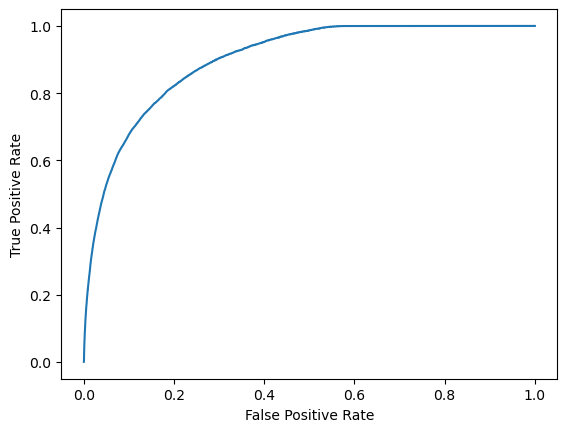

In [45]:
# Получим всевозможные пары FPR, TPR 
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])

# И нарисуем ROC-кривую
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Посчитаем ROC-AUC
auc(fpr, tpr)

In [47]:
test_24_9_22 = pd.read_csv("../input_data/2024-09-22.csv")

test_24_9_22 = test_24_9_22.merge(campaigns_meta[['adv_campaign_id', 'location_id', 'logcat_id',  'num_clicks', 'days', 'category_id']], on=['adv_campaign_id'], how="left")

test_24_9_22['camp'] = test_24_9_22['adv_campaign_id'].map(camp.proportion)

test_24_9_22 = test_24_9_22.fillna(0)

y_24_9_22 = test_24_9_22.target
test_24_9_22 = test_24_9_22.drop(columns=['adv_campaign_id', 'event_date', 'is_main', 'days', 'target', 'Unnamed: 0'])
test_24_9_22 = test_24_9_22.fillna(0)
test_24_9_22.head()

,user_id,platform_id,adv_creative_id,banner_code,location_id,logcat_id,num_clicks,category_id,camp,us
0,327884,2,1599,8,46,40,1768.568747,4,0.322730,0.534759
1,1167448,2,2145,5,1,40,4278.102622,4,0.464610,5.882353
2,3124660,1,4099,7,46,40,1435.407650,4,0.295611,0.273224
3,770841,3,1026,6,45,18,1755.984136,4,0.444433,0.520833
4,1714878,2,1869,8,46,25,1349.649447,4,0.461806,1.063830


In [48]:
X_test.head()

,user_id,platform_id,adv_creative_id,banner_code,location_id,logcat_id,num_clicks,category_id,camp,us
71398,486815,2,381,8,9,30,1810.274748,8,0.514134,0.512821
71399,1489367,2,1167,8,3,57,407.130529,7,0.402361,2.000000
71400,341904,2,736,8,1,65,2040.593992,5,0.501339,2.102102
71401,67845,2,818,8,54,40,1356.905726,4,0.577489,3.603604
71402,3139249,2,3027,8,46,65,1174.113074,5,0.576098,0.952381


In [49]:
proba_24_9_22 = catboost_model.predict_proba(test_24_9_22)[:, 1]
test_24_9_22['proba'] = proba_24_9_22
proba_24_9_22

array([0.06127505, 0.90997465, 0.00618628, ..., 0.66137582, 0.89568789,
       0.86338243])

0.6691542731829253


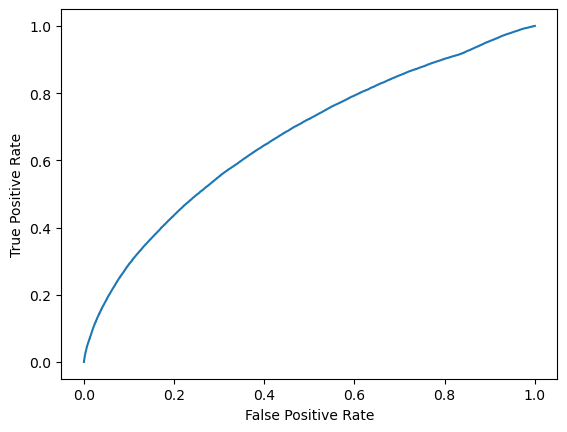

In [50]:
fpr, tpr, thresholds = roc_curve(y_24_9_22, test_24_9_22['proba'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print(auc(fpr, tpr))

In [51]:
aucs = []
train_user = X_train.user_id.unique()

for us in test_24_9_22.user_id.unique():
    
    #if us in train_user:    
    
        uidx = test_24_9_22[test_24_9_22.user_id == us].index    
        fpr, tpr, thresholds = roc_curve(y_24_9_22[uidx], proba_24_9_22[uidx])
        if ~np.isnan(auc(fpr, tpr)): aucs.append(auc(fpr, tpr)) 
        
len(aucs), sum(aucs) / len(aucs)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


(38744, 0.5963458602990646)